### BERT Embeddings

In [1]:
import pandas as pd
import torch
import numpy as np

from src.preprocessing import preprocess_df, TextEncoder, set_labels_features
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer

from src.train import train_mlm

In [2]:
### Constants
FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

MASKING = 0.20

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

### Read dataset

In [3]:
df = pd.read_csv(FILE)

In [4]:
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [5]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS)

### Generate Sequences

In [6]:
# Generate the sequences:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [7]:
mrl.head(3)

itemid,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,Wbc,nstr,lab_ids,lab_values
0,10000032,22595853.0,2180-05-07,0.530612,0.007895,0.258621,0.609524,0.088028,0.585253,0.027731,0.004782,Bic 0.5306122448979591 Crt 0.00789473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.5306122448979591, 0.007894736842105262, 0.2..."
1,10000032,22841357.0,2180-06-27,0.469388,0.007895,0.318966,0.504762,0.102113,0.571429,0.055462,0.007515,Bic 0.46938775510204084 Crt 0.0078947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.007894736842105262, 0...."
2,10000032,25742920.0,2180-08-06,0.489796,0.015789,0.413793,0.504762,0.130282,0.557604,0.053782,0.008539,Bic 0.48979591836734687 Crt 0.0157894736842105...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.48979591836734687, 0.015789473684210523, 0...."


In [8]:
# See the largest element in: 
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019.0,[Bic 0.4489795918367347 Crt 0.0289473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.02894736842105263, 0.17..."
1,20000024.0,[Bic 0.46938775510204084 Crt 0.028947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.02894736842105263, 0.3..."
2,20000034.0,[Bic 0.4489795918367347 Crt 0.0605263157894736...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.06052631578947368, 0.28..."


#### Train and Test Split

In [9]:
lab_ids = grouped_mrl.lab_ids.values
lab_values = grouped_mrl.lab_values.values

lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(lab_ids, lab_values, test_size=0.2, random_state=42)

#### Tokenize

In [10]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)

In [11]:
# Example of how to use the tokenizer:
tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=10)

{'input_ids': array([[ 0,  6,  4,  2,  3,  7,  1,  5, 10, 10],
        [ 0,  6,  4,  2,  3,  7,  1,  5, 10, 10],
        [ 0,  6,  4,  2,  3,  7,  1,  5, 10, 10],
        [ 0,  6,  4,  2,  3,  7,  1,  5, 10, 10],
        [ 0,  6,  4,  2,  3,  7,  1,  5, 10, 10]]),
 'continuous': array([[6.73469388e-01, 7.89473684e-02, 1.46551724e-01, 6.09523810e-01,
         3.80281690e-01, 6.31336406e-01, 4.15966387e-02, 6.94523511e-03,
         1.00000000e+01, 1.00000000e+01],
        [6.12244898e-01, 2.89473684e-02, 1.37931034e-01, 7.04761905e-01,
         9.85915493e-02, 3.50230415e-01, 7.85714286e-02, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [5.30612245e-01, 2.10526316e-02, 2.06896552e-01, 6.28571429e-01,
         5.63380282e-02, 4.42396313e-01, 1.18067227e-01, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [4.48979592e-01, 1.84210526e-02, 2.32758621e-01, 6.28571429e-01,
         3.16901408e-02, 6.77419355e-01, 1.07983193e-01, 1.04747808e-02,
         1.

### Model

In [14]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

# From BERT model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 12
num_blocks = 12
transformer_feedforward_dim = 3072
dropout_rate = 0.1

In [17]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation='relu', dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=3072, bias=True)
        (1): ReLU()
        (2): Linear(in_features=3072, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): D

### Train the model

In [18]:
tokens = tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=10, return_tensors="pt")
lab_id_rand = tokens['input_ids']
lab_rand = tokens['continuous']
attn_mask_rand = tokens['attention_mask']

In [20]:
# Output: {'categorical_output': tensor of shape (batch_size, max_length, vocab_size), 'continuous_output': tensor of shape (batch_size, max_length, 1)}
model(lab_id_rand, lab_rand, attn_mask_rand)

{'categorical_output': tensor([[[0.0854, 0.0849, 0.0883, 0.0551, 0.1498, 0.0924, 0.1291, 0.0982,
           0.0793, 0.0689, 0.0685],
          [0.1020, 0.1050, 0.0908, 0.0733, 0.0933, 0.1017, 0.0906, 0.0874,
           0.0907, 0.0793, 0.0859],
          [0.0870, 0.0677, 0.0776, 0.0932, 0.1214, 0.0996, 0.1090, 0.0901,
           0.0975, 0.0811, 0.0759],
          [0.0970, 0.0822, 0.0827, 0.0707, 0.1267, 0.1143, 0.1149, 0.0893,
           0.0728, 0.0585, 0.0910],
          [0.0953, 0.0708, 0.0691, 0.0713, 0.1112, 0.1236, 0.1140, 0.0962,
           0.0898, 0.0671, 0.0917],
          [0.1033, 0.0742, 0.0838, 0.0639, 0.1254, 0.1086, 0.1217, 0.0909,
           0.0773, 0.0672, 0.0838],
          [0.0870, 0.0803, 0.1015, 0.0719, 0.1263, 0.1034, 0.0889, 0.0926,
           0.0872, 0.0781, 0.0828],
          [0.0819, 0.0707, 0.0864, 0.0588, 0.1192, 0.0846, 0.1407, 0.0968,
           0.1020, 0.0832, 0.0756],
          [0.0980, 0.0831, 0.1005, 0.0741, 0.1139, 0.0952, 0.1075, 0.0926,
           0.09

### Training

/home/opc/anaconda3/envs/labrador/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/13230 [00:00<?, ?it/s]/home/opc/Labrador/src/dataset.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  0%|          | 0/3308 [00:00<?, ?it/s]/home/opc/Labrador/src/dataset.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for 

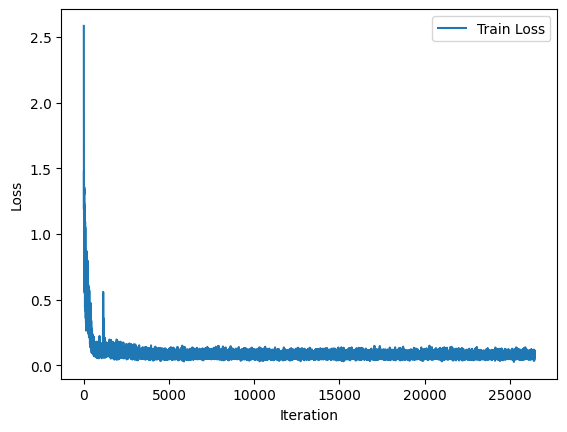

In [16]:
train_mlm(model, train_loader, test_loader, device, tokenizer)

### Load model

In [17]:
model, tokenizer = load_model(model_path="model/", tokenizer_path="tokenizer/")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'CustomBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


### Generate embeddings

In [18]:
texts_to_embed = ["Bic BicAS Crt CrtC Pot PotR Sod SodBI Ure UreG Hgb HgbAQ Plt PltH", "Bic BicBD Crt CrtB Pot PotX"]

embeddings = get_embeddings(model, tokenizer, texts_to_embed)
print("Embeddings Shape:", embeddings.shape)
print(embeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Embeddings Shape: (2, 16, 768)
[[[ 0.64982677 -0.10566206 -1.0763104  ... -0.884716   -0.23258324
    0.3124034 ]
  [ 0.20932955  0.26388958 -0.00180858 ...  0.7378236  -0.09827505
    0.77728575]
  [-0.68087924 -0.04652615 -0.36006537 ...  0.4278307  -0.20046653
    0.08136436]
  ...
  [-0.5111801  -0.31203678 -0.07627459 ...  0.15283796  0.09480215
    0.6543326 ]
  [ 0.21486    -0.07867875  0.20442484 ...  0.12487031 -0.2093614
   -0.65634257]
  [-0.03488328  0.68275726  0.32366392 ... -0.23264171  1.1548079
    0.15274379]]

 [[ 0.63117355 -0.12590797 -1.0669001  ... -0.85015893 -0.24791034
    0.3324585 ]
  [ 0.338554    0.12149534 -0.15336841 ...  0.74225736 -0.0997276
    0.6860133 ]
  [-0.29411113 -0.27056044 -0.42256898 ...  0.7843338  -0.27316344
    0.03977393]
  ...
  [-0.2664884   0.14758384  0.2668739  ... -0.05765764 -0.01213734
    0.1373523 ]
  [-0.19465515  0.19953074  0.2297203  ... -0.07089382 -0.04656379
    0.10606101]
  [-0.12357531  0.1829904   0.25476268 ... -0

### Model to Hugging Face

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
model.push_to_hub("dsrestrepo/BERT_Lab_Values_10B_no_lab_id_no_repetition")
tokenizer.push_to_hub('dsrestrepo/BERT_Lab_Values_10B_no_lab_id_no_repetition')

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dsrestrepo/BERT_Lab_Values_10B_no_lab_id_no_repetition/commit/740ade6f03a779d4e333d84db85364eab740434a', commit_message='Upload tokenizer', commit_description='', oid='740ade6f03a779d4e333d84db85364eab740434a', pr_url=None, pr_revision=None, pr_num=None)